# Análise de sentimento - Comentários de produtos eletrônicos do youtube - Armazenamento no Firebase

In [1]:
from datetime import datetime
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt


import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


import imblearn
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline
sns.set()

from numpy import where


from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE 
# from imblearn.over_sampling import SMOTENC
# from imblearn.over_sampling import SMOTEN
from imblearn.over_sampling import ADASYN 
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SVMSMOTE 

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('src/video_comments_final_types2.csv')
#video_comments = video_comments.T.reset_index().rename(columns={'index': 'comments_id'})

In [135]:
df['final_type'].count()

4906

In [136]:
df['final_type'].value_counts(normalize=True)

 1.0    0.619446
 0.0    0.331227
-1.0    0.049327
Name: final_type, dtype: float64

In [137]:
df['final_type'].value_counts() #1204 1814 1440 2782

 1.0    3039
 0.0    1625
-1.0    242 
Name: final_type, dtype: int64

In [138]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [139]:
df[['final_type','comment']].loc[df['final_type'] == 1]

,final_type,comment
1,1.0,Assistindo com o meu a51 e agora estou querendo o s21 kkkkkkk
2,1.0,Bom eu tenho problemas e com poeira água e queda
7,1.0,"Celular mt bom, vou comprar um"
9,1.0,Eu tô querendo comprar um sansumg tô com medo a bateria não é tão bao
12,1.0,Faz a comparação dele com A02s
...,...,...
4899,1.0,Eu comprei o moto g9play eu ia comprar esse mais o moto g9play e um pouco melhor.
4900,1.0,"Comprei o meu hoje no magazine Luiza, com o cupom de desconto saiu por 1.759 🤗🤗🤗🤗🤗"
4901,1.0,"Entrada em cima , n gosto ! Gosto de entrada embaixo😏. Rocha Dudu 2020!!!;Brinks Dudu 😂😂sou seu fã."
4902,1.0,Sempre quis dizer isso.... assistindo do meu a71 Prata 🥰😁 ele é tudo de bom ..


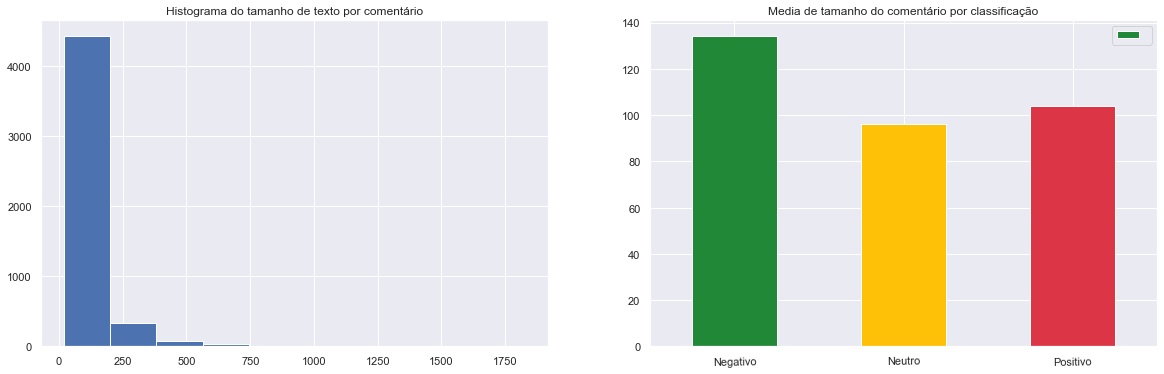

In [140]:
df["comment-len"] = df["comment"].apply(lambda x: len(x))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
axes[0].set_title("Histograma do tamanho de texto por comentário")
df["comment-len"].hist(ax=axes[0], bins=10)

df_grouped = df.groupby("final_type").agg({'comment-len': 'mean'}).reset_index()
df_grouped['desc'] = ["Negativo", "Neutro", "Positivo"]
df_grouped = df_grouped.rename(df_grouped['desc'])

df_grouped.plot.bar(
        y="comment-len",
        label='',
        color=['#218838','#ffc107','#dc3545'], 
        rot=1, 
        title="Media de tamanho do comentário por classificação",
        ax=axes[1])

plt.show()

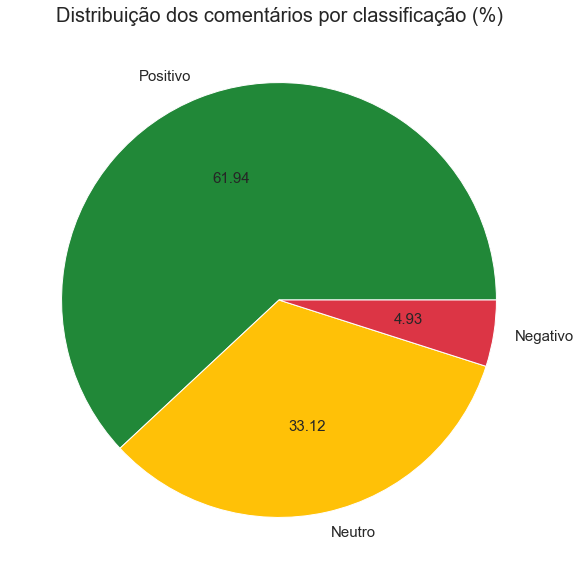

In [141]:
fig = df['final_type'].value_counts(normalize=True).plot.pie(
        autopct="%.2f",
        labels=["Positivo", "Neutro", "Negativo"],
        colors=['#218838','#ffc107','#dc3545'],
        fontsize=15,
        figsize=(10, 10),
        title="Distribuição dos comentários por classificação (%)",
        label="")

fig.axes.title.set_size(20)

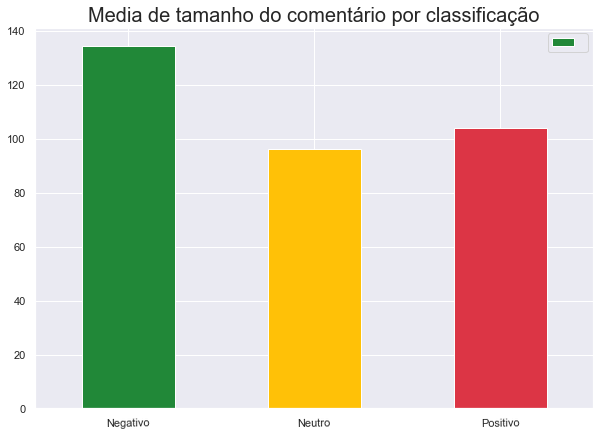

In [142]:
df_grouped = df.groupby("final_type").agg({'comment-len': 'mean'}).reset_index()
df_grouped['desc'] = ["Negativo", "Neutro", "Positivo"]
df_grouped = df_grouped.rename(df_grouped['desc'])
fig = df_grouped.plot.bar(
        y="comment-len",
        label='',
        color=['#218838','#ffc107','#dc3545'], 
        rot=1, 
        title="Media de tamanho do comentário por classificação",
        figsize=(10, 7))
    
fig.axes.title.set_size(20)

#  Data Transform

In [3]:
df['comment'] = df['comment'].astype(str)
df['final_type'] = df['final_type'].astype(int)

In [ ]:
exception = {'!': ':exclamacao:', '?': ':interrogacao:'}

In [5]:
def remove_punctuation(dfText, exception = {}):
    import re
    import string
    regex = re.compile('[%s]' % re.escape(string.punctuation)) #see documentation here: http://docs.python.org/2/library/string.html

    tokenized_docs_no_punctuation = []

    for review in dfText:
        # new_review = []
        new_review = ""
        for token in review:
            new_token = regex.sub(u'', token)
            if not new_token == u'':
                
                #new_review.append(new_token)
                new_review = new_review + new_token
            else:
                for sentence in exception:
                    # print(token,':',sentence)
                    if token == sentence:
                        new_review = new_review +" "+exception[sentence]+" "
                    else:
                        new_review = new_review + " "
        
        tokenized_docs_no_punctuation.append(new_review)
    return tokenized_docs_no_punctuation

def unicode_emoji(dfText):
    import emoji
    for emoj in emoji.UNICODE_EMOJI['pt']:
        dfText = dfText.str.replace(emoj, ' '+emoji.UNICODE_EMOJI['pt'][emoj]+' ', regex=False)
    return dfText

def normalize_utf8(dfText):
    return dfText.str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf8")

def removing_stop_words(dfText):
    import nltk
    nltk.download('stopwords')
    stopwords = nltk.corpus.stopwords.words('portuguese') # removing stop words
    
    stopwords.append('q')
    stopwords.append('pra')
    stopwords.append('td')
    # stopwords.remove('não')

    stopwords = pd.DataFrame(stopwords, columns=['normalized'])
    stopwords['normalized'] = stopwords['normalized'].str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf8")

    stopword_data = []
    for idx,review in enumerate(dfText):
        new_phrase = ""
        for word in review.split(" "):
            # print(word)
            if  not stopwords['normalized'].str.match('^'+word+'$').any():
                new_phrase = new_phrase + " " + word

        stopword_data.append(new_phrase)

    return stopword_data

def portuguese_stemmer(dfText):
    # #!pip install git+git://github.com/snowballstem/pystemmer
    import Stemmer
    stemmer = Stemmer.Stemmer('portuguese')

    stemmer_docs = []
    for phrase in dfText:
        stemmer_docs.append(' '.join(stemmer.stemWords(phrase.split(" "))))

    return stemmer_docs

def excess_space_remover(dfText):
    all_commnets_list = dfText.to_list()

    for i in range(len(all_commnets_list)):
        all_commnets_list[i] = re.sub(r"\s+", " ", all_commnets_list[i])

    return all_commnets_list

def lower_case(dfText):
    return dfText.str.lower()

In [6]:
df['transformed_comment'] = lower_case(df['comment']) 
df['transformed_comment'] = remove_punctuation(df['transformed_comment'], exception) 
df['transformed_comment'] = unicode_emoji(df['transformed_comment'])
df['transformed_comment'] = normalize_utf8(df['transformed_comment'])
df['transformed_comment'] = removing_stop_words(df['transformed_comment'])
df['transformed_comment'] = portuguese_stemmer(df['transformed_comment'])
df['transformed_comment'] = excess_space_remover(df['transformed_comment'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erycm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Imbalance Apply

In [147]:
def overSamplDef(X_res, y_res, overMethod):
    from collections import Counter
    from imblearn.over_sampling import RandomOverSampler
    from imblearn.over_sampling import SMOTE 
    # from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN
    from imblearn.over_sampling import ADASYN 
    from imblearn.over_sampling import BorderlineSMOTE
    from imblearn.over_sampling import KMeansSMOTE
    from imblearn.over_sampling import SVMSMOTE 
    

    print('Before dataset shape %s' % sorted(Counter(y_res).items()))
    ros = overMethod(sampling_strategy='minority')
    # ros = BorderlineSMOTE()
    # sampling_strategy='minority'
    # ros = SMOTE()
    X_res, y_res = ros.fit_resample(X_res, y_res)

    print('Resampled dataset shape %s' % sorted(Counter(y_res).items()))
    print("-------------------------------------------")


    return X_res, y_res

# Create Features

In [148]:
# required_columns = 'comment'
required_columns = 'transformed_comment'
le = LabelEncoder()

X = df[required_columns]
y = le.fit_transform(df['final_type'])

In [149]:
count_vec = CountVectorizer()
X_counts = count_vec.fit_transform(X)
# count_vec_ngram = CountVectorizer(ngram_range=(2, 2))
count_vec_ngram = CountVectorizer(ngram_range=(2, 3))
#count_vec = CountVectorizer(vocabulary=count_vec.vocabulary_)
# count_vec = CountVectorizer()
X_counts_bigram = count_vec_ngram.fit_transform(X)
#X_counts_bigram = count_vec_ngram.transform(X)

tf = TfidfTransformer(use_idf=False, norm="l1")
X_freq = tf.fit_transform(X_counts)

tf = TfidfTransformer(norm="l1")
X_tfidf = tf.fit_transform(X_counts)

In [150]:
X_freq.shape

(4906, 5556)

In [151]:
# X_counts.reshape(-1,1)
# y.reshape(-1,1)

X_train_counts, X_test_counts, y_train_counts, y_test_counts = train_test_split(X_counts, y, test_size=.2)
X_train_bigram, X_test_bigram, y_train_bigram, y_test_bigram = train_test_split(X_counts_bigram, y, test_size=.2)
X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(X_freq, y, test_size=.2)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=.2)

In [152]:
X_train_counts, y_train_counts = overSamplDef(X_train_counts, y_train_counts, ADASYN) #SMOTE or RandomOverSampler | BorderlineSMOTE (pior)
X_train_bigram, y_train_bigram = overSamplDef(X_train_bigram, y_train_bigram, ADASYN) #ADASYN (resultado ruim) | BorderlineSMOTE (mal distribuido)
X_train_freq, y_train_freq = overSamplDef(X_train_freq, y_train_freq, ADASYN) #RandomOverSampler or SMOTE | SVMSMOTE or RandomOverSampler
X_train_tfidf, y_train_tfidf = overSamplDef(X_train_tfidf, y_train_tfidf, ADASYN) #SMOTE | SMOTE


Before dataset shape [(0, 191), (1, 1319), (2, 2414)]
Resampled dataset shape [(0, 2369), (1, 1319), (2, 2414)]
-------------------------------------------
Before dataset shape [(0, 206), (1, 1276), (2, 2442)]
Resampled dataset shape [(0, 2424), (1, 1276), (2, 2442)]
-------------------------------------------
Before dataset shape [(0, 187), (1, 1301), (2, 2436)]
Resampled dataset shape [(0, 2417), (1, 1301), (2, 2436)]
-------------------------------------------
Before dataset shape [(0, 202), (1, 1291), (2, 2431)]
Resampled dataset shape [(0, 2410), (1, 1291), (2, 2431)]
-------------------------------------------


# Training Model

In [153]:
mNB = MultinomialNB()

clf_counts = MultinomialNB().fit(X_train_counts, y_train_counts)
clf_bigram = MultinomialNB().fit(X_train_bigram, y_train_bigram)
clf_freq = MultinomialNB().fit(X_train_freq, y_train_freq)
clf_tfidf = MultinomialNB().fit(X_train_tfidf, y_train_tfidf)

In [154]:
y_pred_counts = clf_counts.predict(X_test_counts)
y_pred_bigram = clf_bigram.predict(X_test_bigram)
y_pred_freq = clf_freq.predict(X_test_freq)
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

In [155]:
param_grid = [
  {'C': [1, 10, 100, 1000]}
 ]
svc = LinearSVC()
clf_counts = GridSearchCV(svc, param_grid).fit(X_train_counts, y_train_counts)
clf_bigram = GridSearchCV(svc, param_grid).fit(X_train_bigram, y_train_bigram)
clf_freq = GridSearchCV(svc, param_grid).fit(X_train_freq, y_train_freq)
clf_tfidf = GridSearchCV(svc, param_grid).fit(X_train_tfidf, y_train_tfidf)

In [156]:
svm_y_pred_counts = clf_counts.predict(X_test_counts)
svm_y_pred_bigram = clf_bigram.predict(X_test_bigram)
svm_y_pred_freq = clf_freq.predict(X_test_freq)
svm_y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

# Check Accuracy

In [157]:
target_names = ['Negativo', 'Neutro', 'Positivo']

print("MNB - Acuracia de counts")
print(classification_report(y_test_counts, y_pred_counts, target_names=target_names))
print("-----------------------------------------------------")
print("MNB - Acuracia de bigram")
print(classification_report(y_test_bigram, y_pred_bigram, target_names=target_names))
print("-----------------------------------------------------")

MNB - Acuracia de counts
              precision    recall  f1-score   support

    Negativo       0.11      0.25      0.16        51
      Neutro       0.40      0.30      0.34       306
    Positivo       0.68      0.69      0.69       625

    accuracy                           0.55       982
   macro avg       0.40      0.42      0.39       982
weighted avg       0.56      0.55      0.55       982

-----------------------------------------------------
MNB - Acuracia de bigram
              precision    recall  f1-score   support

    Negativo       0.05      0.97      0.10        36
      Neutro       0.41      0.16      0.23       349
    Positivo       0.65      0.17      0.27       597

    accuracy                           0.19       982
   macro avg       0.37      0.43      0.20       982
weighted avg       0.54      0.19      0.25       982

-----------------------------------------------------


In [158]:
print("MNB - Acuracia de freq")
print(classification_report(y_test_freq, y_pred_freq, target_names=target_names))
print("-----------------------------------------------------")
print("MNB - Acuracia de tfidf")
print(classification_report(y_test_tfidf, y_pred_tfidf, target_names=target_names))
print("-----------------------------------------------------")

MNB - Acuracia de freq
              precision    recall  f1-score   support

    Negativo       0.11      0.47      0.18        55
      Neutro       0.00      0.00      0.00       324
    Positivo       0.62      0.77      0.69       603

    accuracy                           0.50       982
   macro avg       0.24      0.42      0.29       982
weighted avg       0.39      0.50      0.43       982

-----------------------------------------------------
MNB - Acuracia de tfidf
              precision    recall  f1-score   support

    Negativo       0.10      0.47      0.16        40
      Neutro       0.00      0.00      0.00       334
    Positivo       0.64      0.82      0.72       608

    accuracy                           0.53       982
   macro avg       0.24      0.43      0.29       982
weighted avg       0.40      0.53      0.45       982

-----------------------------------------------------


In [159]:
print("SVM - Acuracia de counts")
print(classification_report(y_test_counts, svm_y_pred_counts, target_names=target_names))
print("-----------------------------------------------------")
print("SVM - Acuracia de bigram")
print(classification_report(y_test_bigram, svm_y_pred_bigram, target_names=target_names))
print("-----------------------------------------------------")

SVM - Acuracia de counts
              precision    recall  f1-score   support

    Negativo       0.07      0.20      0.10        51
      Neutro       0.36      0.32      0.34       306
    Positivo       0.65      0.59      0.62       625

    accuracy                           0.48       982
   macro avg       0.36      0.37      0.35       982
weighted avg       0.53      0.48      0.50       982

-----------------------------------------------------
SVM - Acuracia de bigram
              precision    recall  f1-score   support

    Negativo       0.05      0.86      0.09        36
      Neutro       0.29      0.09      0.13       349
    Positivo       0.63      0.26      0.37       597

    accuracy                           0.22       982
   macro avg       0.32      0.40      0.20       982
weighted avg       0.49      0.22      0.28       982

-----------------------------------------------------


In [160]:
print("SVM - Acuracia de freq")
print(classification_report(y_test_freq, svm_y_pred_freq, target_names=target_names))
print("-----------------------------------------------------")
print("SVM - Acuracia de tfidf")
print(classification_report(y_test_tfidf, svm_y_pred_tfidf, target_names=target_names))

SVM - Acuracia de freq
              precision    recall  f1-score   support

    Negativo       0.14      0.18      0.16        55
      Neutro       0.35      0.34      0.34       324
    Positivo       0.62      0.62      0.62       603

    accuracy                           0.50       982
   macro avg       0.37      0.38      0.37       982
weighted avg       0.50      0.50      0.50       982

-----------------------------------------------------
SVM - Acuracia de tfidf
              precision    recall  f1-score   support

    Negativo       0.05      0.07      0.06        40
      Neutro       0.37      0.26      0.31       334
    Positivo       0.64      0.72      0.67       608

    accuracy                           0.54       982
   macro avg       0.35      0.35      0.35       982
weighted avg       0.52      0.54      0.52       982



In [161]:
print("SVM - Acuracia de freq")
print(classification_report(y_test_freq, svm_y_pred_freq, target_names=target_names))
print("-----------------------------------------------------")
print("SVM - Acuracia de tfidf")
print(classification_report(y_test_tfidf, svm_y_pred_tfidf, target_names=target_names))

SVM - Acuracia de freq
              precision    recall  f1-score   support

    Negativo       0.14      0.18      0.16        55
      Neutro       0.35      0.34      0.34       324
    Positivo       0.62      0.62      0.62       603

    accuracy                           0.50       982
   macro avg       0.37      0.38      0.37       982
weighted avg       0.50      0.50      0.50       982

-----------------------------------------------------
SVM - Acuracia de tfidf
              precision    recall  f1-score   support

    Negativo       0.05      0.07      0.06        40
      Neutro       0.37      0.26      0.31       334
    Positivo       0.64      0.72      0.67       608

    accuracy                           0.54       982
   macro avg       0.35      0.35      0.35       982
weighted avg       0.52      0.54      0.52       982



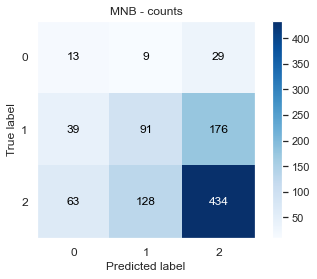

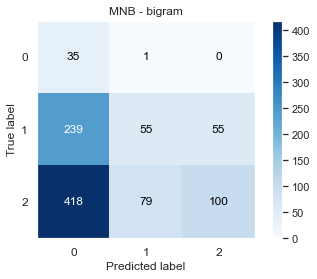

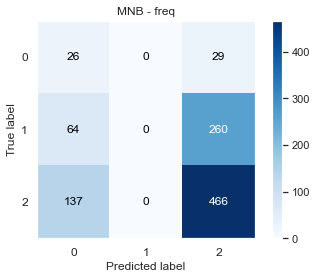

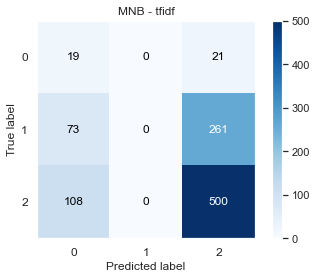

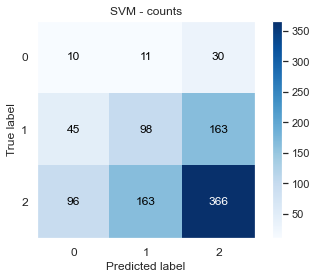

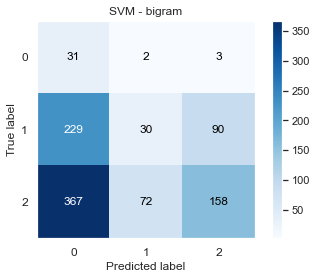

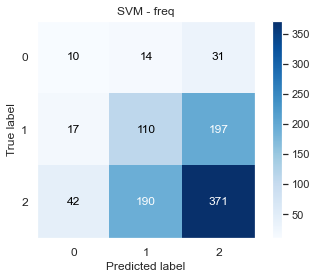

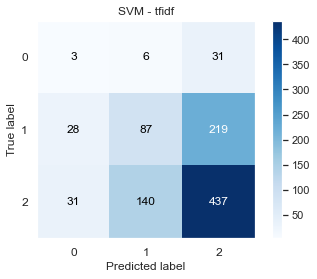

In [162]:
import matplotlib.pyplot as plt

disp = plot_confusion_matrix(y_test_counts, y_pred_counts)
disp.set_title('MNB - counts')
disp = plot_confusion_matrix(y_test_bigram, y_pred_bigram)
disp.set_title('MNB - bigram')
disp = plot_confusion_matrix(y_test_freq, y_pred_freq)
disp.set_title('MNB - freq')
disp = plot_confusion_matrix(y_test_tfidf, y_pred_tfidf)
disp.set_title('MNB - tfidf')

disp = plot_confusion_matrix(y_test_counts, svm_y_pred_counts)
disp.set_title('SVM - counts')
disp = plot_confusion_matrix(y_test_bigram, svm_y_pred_bigram)
disp.set_title('SVM - bigram')
disp = plot_confusion_matrix(y_test_freq, svm_y_pred_freq)
disp.set_title('SVM - freq')
disp = plot_confusion_matrix(y_test_tfidf, svm_y_pred_tfidf)
disp.set_title('SVM - tfidf')


plt.show()

In [163]:
df['final_type'].value_counts()

 1    3039
 0    1625
-1    242 
Name: final_type, dtype: int64

In [164]:
required_columns = 'transformed_comment'
le = LabelEncoder()

X = df[required_columns]
y = le.fit_transform(df['final_type'])
count_vec = CountVectorizer()
X_counts = count_vec.fit_transform(X)
tf = TfidfTransformer(norm='l1')
X_tfidf = tf.fit_transform(X_counts)

model_report = pd.DataFrame()
predict_tfidf_mnb = []
target_names = ['Negativo', 'Neutro', 'Positivo']
for exec in range(600):
    mNB = MultinomialNB()
    X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=.2)
    X_train_tfidf, y_train_tfidf = overSamplDef(X_train_tfidf, y_train_tfidf, ADASYN)
    clf_tfidf = mNB.fit(X_train_tfidf, y_train_tfidf)
    y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

    tfidf_mnb = classification_report(y_test_tfidf, y_pred_tfidf, target_names=target_names,  output_dict=True)
    predict_tfidf_mnb.append(tfidf_mnb)

model_tfidf_mnb_report = pd.json_normalize(predict_tfidf_mnb)

Before dataset shape [(0, 200), (1, 1300), (2, 2424)]
Resampled dataset shape [(0, 2399), (1, 1300), (2, 2424)]
-------------------------------------------
Before dataset shape [(0, 190), (1, 1285), (2, 2449)]
Resampled dataset shape [(0, 2462), (1, 1285), (2, 2449)]
-------------------------------------------
Before dataset shape [(0, 196), (1, 1308), (2, 2420)]
Resampled dataset shape [(0, 2392), (1, 1308), (2, 2420)]
-------------------------------------------
Before dataset shape [(0, 204), (1, 1284), (2, 2436)]
Resampled dataset shape [(0, 2485), (1, 1284), (2, 2436)]
-------------------------------------------
Before dataset shape [(0, 201), (1, 1320), (2, 2403)]
Resampled dataset shape [(0, 2439), (1, 1320), (2, 2403)]
-------------------------------------------
Before dataset shape [(0, 201), (1, 1293), (2, 2430)]
Resampled dataset shape [(0, 2468), (1, 1293), (2, 2430)]
-------------------------------------------
Before dataset shape [(0, 187), (1, 1293), (2, 2444)]
Resampled 

In [165]:
# comments_test = ['Odiei esse celular! Bateria Péssima 😡', 'Adorei esse Celular', 'Muito bom!', 'Qual seria melhor ?']
# comments_test = pd.DataFrame({'comments': comments_test})
# comments_test['transformed_comment'] = lower_case(comments_test['comments']) 
# comments_test['transformed_comment'] = comments_test['transformed_comment'].str.replace('!', ' :exclamacao: ')
# comments_test['transformed_comment'] = comments_test['transformed_comment'].str.replace('?', ' :interrogacao: ')
# comments_test['transformed_comment'] = remove_punctuation(comments_test['transformed_comment']) 
# comments_test['transformed_comment'] = unicode_emoji(comments_test['transformed_comment'])
# comments_test['transformed_comment'] = normalize_utf8(comments_test['transformed_comment'])
# comments_test['transformed_comment'] = removing_stop_words(comments_test['transformed_comment'])
# comments_test['transformed_comment'] = portuguese_stemmer(comments_test['transformed_comment'])
# comments_test['transformed_comment'] = excess_space_remover(comments_test['transformed_comment'])

In [166]:
model_tfidf_mnb_report

,accuracy,Negativo.precision,Negativo.recall,Negativo.f1-score,Negativo.support,Neutro.precision,Neutro.recall,Neutro.f1-score,Neutro.support,Positivo.precision,Positivo.recall,Positivo.f1-score,Positivo.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall,weighted avg.f1-score,weighted avg.support
0,0.523422,0.103448,0.500000,0.171429,42,0.0,0.0,0.0,325,0.632863,0.801626,0.707317,615,0.245437,0.433875,0.292915,982,0.400769,0.523422,0.450305,982
1,0.489817,0.107884,0.500000,0.177474,52,0.0,0.0,0.0,340,0.614035,0.771186,0.683696,590,0.240640,0.423729,0.287057,982,0.374634,0.489817,0.420173,982
2,0.531568,0.095694,0.434783,0.156863,46,0.0,0.0,0.0,317,0.649418,0.810985,0.721264,619,0.248371,0.415256,0.292709,982,0.413841,0.531568,0.461994,982
3,0.475560,0.089928,0.657895,0.158228,38,0.0,0.0,0.0,341,0.627841,0.733002,0.676358,603,0.239256,0.463632,0.278195,982,0.389007,0.475560,0.421443,982
4,0.510183,0.098814,0.609756,0.170068,41,0.0,0.0,0.0,305,0.652949,0.748428,0.697436,636,0.250588,0.452728,0.289168,982,0.427013,0.510183,0.458800,982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.529532,0.106599,0.437500,0.171429,48,0.0,0.0,0.0,306,0.635669,0.794586,0.706299,628,0.247423,0.410695,0.292576,982,0.411728,0.529532,0.460065,982
596,0.511202,0.105023,0.469388,0.171642,49,0.0,0.0,0.0,324,0.627785,0.786535,0.698251,609,0.244269,0.418641,0.289964,982,0.394569,0.511202,0.441594,982
597,0.532587,0.115385,0.558140,0.191235,43,0.0,0.0,0.0,330,0.644703,0.819376,0.721620,609,0.253362,0.459172,0.304285,982,0.404873,0.532587,0.455896,982
598,0.515275,0.101523,0.476190,0.167364,42,0.0,0.0,0.0,342,0.619108,0.812709,0.702820,598,0.240210,0.429633,0.290061,982,0.381355,0.515275,0.435148,982


In [167]:
print(model_tfidf_mnb_report['Negativo.recall'].mean())
print(model_tfidf_mnb_report['Neutro.recall'].mean())
print(model_tfidf_mnb_report['Positivo.recall'].mean())

0.5058030365092849
0.0
0.7840634228932901


In [168]:
print(model_tfidf_mnb_report['Negativo.precision'].mean())
print(model_tfidf_mnb_report['Neutro.precision'].mean())
print(model_tfidf_mnb_report['Positivo.precision'].mean())

0.10724104570819648
0.0
0.6315125846126205


<AxesSubplot:ylabel='Frequency'>

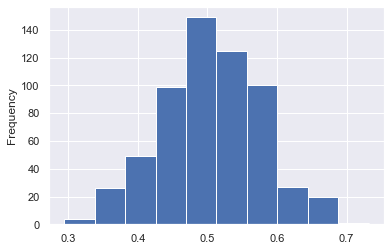

In [169]:
model_tfidf_mnb_report['Negativo.recall'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

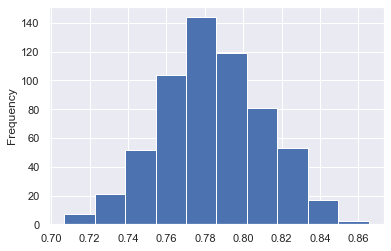

In [170]:
model_tfidf_mnb_report['Positivo.recall'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

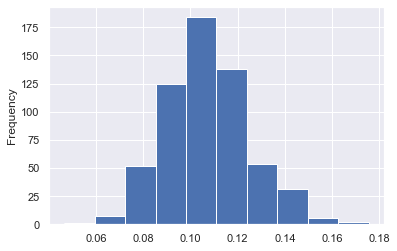

In [171]:
model_tfidf_mnb_report['Negativo.precision'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

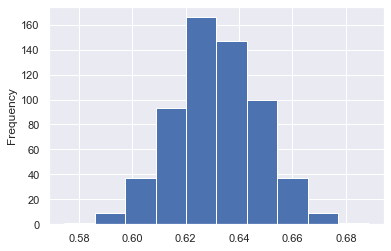

In [172]:
model_tfidf_mnb_report['Positivo.precision'].plot.hist()